<a href="https://colab.research.google.com/github/komisarzGiT/gai/blob/main/UG_ML02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Marcin Byra  
Class: 2526-1MAO2  
Student ID: 25258161

Assignment 2  
Classification of Seizure using Machine Learning Classifiers and EEG Data

The objective is to
Cardiac Health Records

In [29]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

In [30]:
#Cardiac Health Records
cardiac_data = 'https://raw.githubusercontent.com/komisarzGiT/gai/refs/heads/main/GU_ML01/Assignment2/Modified_Heart_failure_data.csv'

df_cardiac_data = pd.read_csv(cardiac_data)

#no split into train and test sets
#there are no know labels and objective is not prediction but categorization

#check data types
print(f"Data types \n{df_cardiac_data.dtypes}")

Data types 
age                         float64
anaemia                     float64
creatinine_phosphokinase    float64
diabetes                    float64
ejection_fraction           float64
high_blood_pressure         float64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                         float64
smoking                     float64
time                        float64
patient_id                    int64
dtype: object


In [31]:
cardiac_rows, cardiac_columns = df_cardiac_data.shape
print(f"Cardiac health data set has {cardiac_rows} observations and {cardiac_columns} variables. Sample data:")
display(df_cardiac_data.head(3))

Cardiac health data set has 299 observations and 13 variables. Sample data:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,patient_id
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1
2,65.0,NaN,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,NaN,7.0,2


NEED TO Fill gaps sing all available data ensures the discovered clusters (the patient profiles) are the most representative and stable for the entire population being studied.

In [32]:
missing_values = df_cardiac_data.isnull().sum()
print("Missing Values\n", missing_values)

Missing Values
 age                         29
anaemia                     29
creatinine_phosphokinase    29
diabetes                    29
ejection_fraction           29
high_blood_pressure         29
platelets                   29
serum_creatinine            29
serum_sodium                29
sex                         29
smoking                     29
time                        29
patient_id                   0
dtype: int64


In [33]:
#To fill missing values, distinguish between categorical binary and continous variables.
#Visual data inspection as well as count of valeus cna help here

unique_counts = df_cardiac_data.nunique()
print(unique_counts)

age                          47
anaemia                       2
creatinine_phosphokinase    193
diabetes                      2
ejection_fraction            16
high_blood_pressure           2
platelets                   161
serum_creatinine             37
serum_sodium                 23
sex                           2
smoking                       2
time                        141
patient_id                  299
dtype: int64


In [34]:
# Binary (mode imputation)

binary_cols = [ 'anaemia', 'diabetes', 'high_blood_pressure',
    'sex', 'smoking' ]

# Continuous (median imputation)
continuous_cols = [ 'age', 'creatinine_phosphokinase', 'ejection_fraction',
    'platelets', 'serum_creatinine', 'serum_sodium', 'time' ]

from sklearn.impute import SimpleImputer

# remove patient ID for all further processing
df_cardiac_fill = df_cardiac_data.drop('patient_id', axis=1)


# Impute Continuous Columns with the Median
# The median is robust to outliers, which is crucial for features like CPK and Platelets.
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_cardiac_fill[continuous_cols] = imputer_median.fit_transform(df_cardiac_fill[continuous_cols])

# --- 3. Impute Binary/Categorical Columns with the Mode (Most Frequent) ---
# The mode preserves the discrete nature of these indicator variables (0 or 1).
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cardiac_fill[binary_cols] = imputer_mode.fit_transform(df_cardiac_fill[binary_cols])

# Convert binary/categorical columns to integer type
for col in binary_cols:
    df_cardiac_fill[col] = df_cardiac_fill[col].astype(int)

# Check for remaining missing values to confirm imputation success
print(df_cardiac_fill.isnull().sum())


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64


In [35]:
#To understand which features are most likely to be influential during the preprocessing step,
#before running any clustering algorithm. The most robust method for this is Principal Component Analysis (PCA).
#PCA is a dimensionality reduction technique that finds the directions (components)
# in your scaled data that capture the maximum amount of variance. The features that contribute most to these high-variance directions are inherently the most important for defining the dataset's structure.


# Scale the data (Crucial step for PCA)
scaler = StandardScaler()
df_cardiac_scalled = scaler.fit_transform(df_cardiac_fill)


#PCA

# Initialize PCA to reduce the 11 features to 2 components (PC1 and PC2)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_cardiac_scalled)

# Create a DataFrame for the PCA results
df_cardiac_pca2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
# The original 'feature_names' were incorrect here, as they referred to the PCA result columns.
# The index for loadings should be the original feature names from df_cardiac_fill.

print("--- PCA Explained Variance Ratio ---")
print(f"PC1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained by 2 components: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.2f}%")

print("\n--- PCA Transformed Data Head ---")
print(df_cardiac_pca2.head())

# Fix: Use the original column names from df_cardiac_fill as the index for the loadings DataFrame
print(df_cardiac_fill.columns)
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_cardiac_fill.columns)
display(loadings_df)

--- PCA Explained Variance Ratio ---
PC1 explains: 13.28% of variance
PC2 explains: 12.21% of variance
Total variance explained by 2 components: 25.49%

--- PCA Transformed Data Head ---
        PC1       PC2
0  0.410840 -2.658527
1  2.455400  0.725972
2  1.081660 -2.267475
3  0.007465 -1.206092
4 -0.862545 -4.215684
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


,PC1,PC2
age,-0.091808,-0.416441
anaemia,-0.415135,-0.246599
creatinine_phosphokinase,0.247574,0.143837
diabetes,-0.081168,0.018772
ejection_fraction,-0.267044,0.260671
high_blood_pressure,-0.254858,-0.013317
platelets,-0.104631,0.143586
serum_creatinine,-0.004994,-0.475510
serum_sodium,-0.142739,0.420485
sex,0.562540,-0.154153


Why Standardization is Essential for Clustering
1. Eliminating Scale Bias in Distance Metrics

features with larger magnitudes will disproportionately dominate the distance calculation, leading to a phenomenon known as Scale Bias
creatinine_phosphokinase (CPK) values can reach into the thousands (e.g., $7861.0$), while age is in the 50–90 range, and serum_creatinine is typically under $3.0$.

By ensuring all features have the same variance and scale, the Standardization process guarantees that:

Equal Contribution: Every feature contributes equally to the distance calculation, regardless of its original units or magnitude.

Accurate Proximity: The proximity between patients is defined by their relative differences (in terms of standard deviations from the mean), which accurately reflects the inherent structure of the data rather than being an artifact of the measurement units.

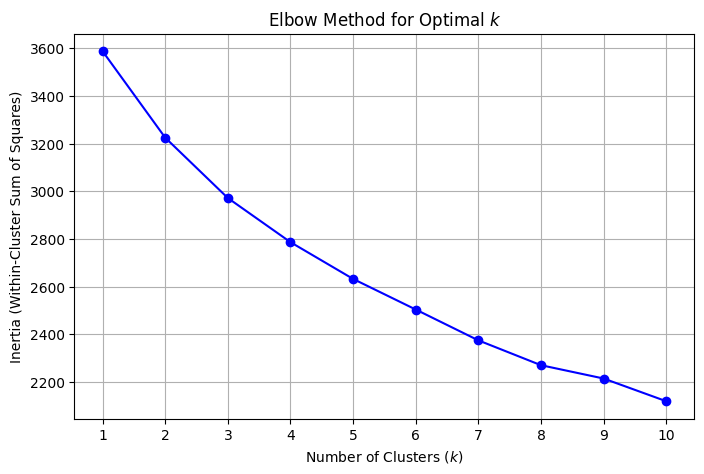

In [37]:
# --- 2. Determining Optimal k (Elbow Method) ---
inertia = []
K_range = range(1, 11) #maximum number of centroids the same as mnumber of features

for k in K_range:
    # Set n_init=10 for robustness
    # use k-means++ for probabilistic centroid placement
    # repat 10 times, take highest inertia
    kmeans_elbow = KMeans(n_clusters=k, random_state=13, init='k-means++', n_init=10)
    kmeans_elbow.fit(df_cardiac_scalled)
    inertia.append(kmeans_elbow.inertia_)


# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method for Optimal $k$')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.savefig("elbow_method.png")
plt.show()

In [39]:
# Create a DataFrame for inertia and K_range
elbow_data = pd.DataFrame({
    'Number of Clusters (k)': K_range,
    'Inertia': inertia
})

# Calculate the decrease in inertia from the previous k
elbow_data['Inertia Decrease'] = elbow_data['Inertia'].diff().abs()

print("Elbow Method Data (Inertia and Decrease):")
display(elbow_data)

Elbow Method Data (Inertia and Decrease):


,Number of Clusters (k),Inertia,Inertia Decrease
0,1,3588.000000,NaN
1,2,3225.231266,362.768734
2,3,2971.941516,253.289751
3,4,2786.672195,185.269321
4,5,2632.410376,154.261819
5,6,2503.989754,128.420622
6,7,2374.595219,129.394535
7,8,2270.330850,104.264369
8,9,2214.441252,55.889599
9,10,2119.145729,95.295523
